In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vishwajeet172","key":"2f59629e40bd84eaf17d64acb546af19"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d snap/amazon-fine-food-reviews
!unzip amazon-fine-food-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0
amazon-fine-food-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  amazon-fine-food-reviews.zip
replace Reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace database.sqlite? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace hashes.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import pandas as pd

df = pd.read_csv("Reviews.csv")
df = df[df['Score'] != 3]  # Remove neutral (3-star) reviews

df['review_label'] = df['Score'].apply(lambda x: 'positive' if x > 3 else 'negative')
df = df[['Text', 'review_label']]
print(df['review_label'].value_counts())

review_label
positive    443777
negative     82037
Name: count, dtype: int64


In [ ]:
# Separate positive and negative reviews
pos = df[df['review_label'] == 'positive']
neg = df[df['review_label'] == 'negative']

# Downsample positives to match negatives
pos_sampled = pos.sample(n=len(neg), random_state=42)

# Combine and shuffle
df_balanced = pd.concat([pos_sampled, neg]).sample(frac=1, random_state=42).reset_index(drop=True)

# Confirm balance
print(df_balanced['review_label'].value_counts())

review_label
positive    82037
negative    82037
Name: count, dtype: int64


In [ ]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download("stopwords")

stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = text.split()  # ← simpler than nltk.word_tokenize()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df_balanced['cleaned_text'] = df_balanced['Text'].apply(clean_text)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
X = vectorizer.fit_transform(df_balanced['cleaned_text'])
y = df_balanced['review_label']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=0.1)
model.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

Accuracy: 0.8713698003961603

Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.86      0.87     16382
    positive       0.87      0.88      0.87     16433

    accuracy                           0.87     32815
   macro avg       0.87      0.87      0.87     32815
weighted avg       0.87      0.87      0.87     32815



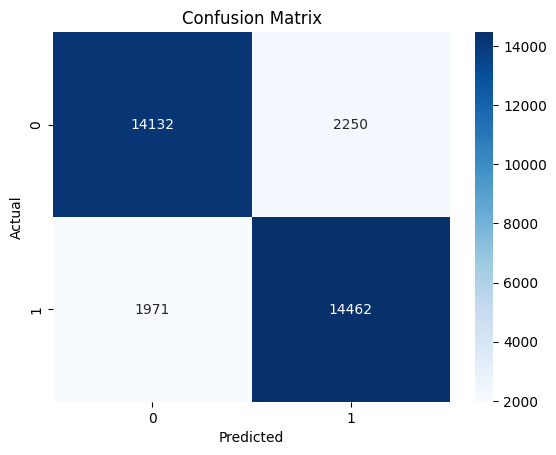

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    vectorized = vectorizer.transform([cleaned])
    prediction = model.predict(vectorized)
    return prediction[0]

# Try these:
print(predict_sentiment("I absolutely love this product! Works great."))
print(predict_sentiment("Worst purchase ever. Completely disappointed."))

positive
negative


In [ ]:
print(predict_sentiment("Worst thing absolutely"))

negative


In [ ]:
print(predict_sentiment("Someone should delete this product"))

negative


In [ ]:
print(predict_sentiment("marvelous item"))

positive


In [ ]:
print(predict_sentiment("Hell yeah wow"))

negative


In [ ]:
print(predict_sentiment("good"))

positive


In [ ]:
import pickle

# Save model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [ ]:
from google.colab import files
files.download('model.pkl')
files.download('vectorizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>